In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
from os import path as osp
import sys
# !unzip -oq "gdrive/My Drive/NTF_project/200Ra5e6data.zip" 
## unzip file 
if not os.path.exists("500Ra3.0E+06_dt1.0E+00_SD1830312345"):
    !unzip -oq "gdrive/My Drive/NTF_project/500Ra3.0E+06_dt1.0E+00_SD1830312345.zip" -d "500Ra3.0E+06_dt1.0E+00_SD1830312345"

In [4]:
root_dir = "gdrive/My Drive/NTF_project/DMD/src"
save_dir = "gdrive/My Drive/NTF_project/"

In [5]:
import os 
import sys
src_path = ['../src', 'src',root_dir]
for path in src_path:
    if os.path.exists(path):
        sys.path.append(path)
        print(f"src path: {path}")
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import copy
import pickle
# plt.style.use('ggplot')
import h5py
import utils_dmd
# import dmd_tools
from Pydmd.dmd import DMD
# from dmd_dev import plot_EigVal
from multiprocessing import Pool
from functools import partial
import comm_tools
import dmd_tools

from Pydmd.help_func import plot_recons_err_rank


src path: gdrive/My Drive/NTF_project/DMD/src


In [6]:
### DMD for velocity of inregular pattern of rayleigh benard convection
## data folder
root_dir = "gdrive/My Drive/NTF_project/DMDmain"
file_path ='500Ra3.0E+06_dt1.0E+00_SD1830312345/data'

data_p_list = [os.path.join(file_path, f) for f in os.listdir(file_path)]
data_p_list = sorted(data_p_list)
data = []
data_ux = []
data_uy = []
for p in data_p_list:
    with h5py.File(p, "r") as f:
        # d_t = f['T'][()]
        # print(f.keys())
        d_ux = f['ux'][()]
        d_uy = f['uy'][()]
    # print(f.keys())
        # data.append(d_t.flatten())
        data_ux.append(d_ux.flatten())
        data_uy.append(d_uy.flatten())

with h5py.File(p, "r") as f:
     Nx = f['X_mesh'][()]
     Ny = f['Y_mesh'][()]

ny, nx = Nx.shape
# data = np.stack(data,1)
data_uy = np.stack(data_uy,1)
data_ux = np.stack(data_ux,1)
data = np.sqrt(data_ux**2 + data_uy**2)
snapshots = data

In [7]:
f_suffix= 'U_1'

In [8]:
data.shape

(100000, 1000)

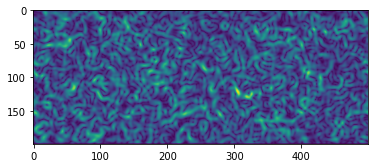

In [9]:
plt.imshow(snapshots[:, 0].reshape(ny,nx))

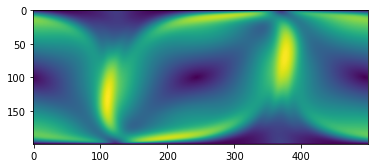

In [10]:
plt.imshow(snapshots[:, 700].reshape(ny,nx))

In [11]:
# data = data[:, :100]

In [12]:
dmd_ext = DMD(svd_rank=0, exact=True, nx=nx,ny=ny)
print('fitting...')
with comm_tools.Timer('fitting'):
    dmd_ext.fit(snapshots[:,100:300])
#         dmd_p.fit(snapshots)
print('fitted')
# else:
#     print('fitting VORLL...')
#     dt = 1
#     # dt = t[1] - t[0]
#     with comm_tools.Timer('fitting'):
#         dmd.fit(VORLL_data)
#     print('fitted')

fitting...
[fitting]
Elapsed: 9.147867441177368
fitted


In [13]:
dmd_ext.modes.shape

(100000, 87)

In [14]:
r_svd = dmd_ext.r_svd 
dmd_amplitudes = dmd_ext.amplitudes
cri16_idx = dmd_ext.item_sort_idx('cri16')
eigval = dmd_ext.eigs[cri16_idx]

sort_method: cri16


In [15]:
dmd_ext.item_sort_idx('cri16')

sort_method: cri16


array([62, 67, 68, 70, 69, 72, 71, 77, 78, 83, 84, 85, 86, 73, 74, 80, 79,
       66, 65, 82, 81, 61, 60, 64, 63, 76, 75, 57, 56, 58, 59, 55, 54, 44,
       45, 52, 53, 43, 42, 51, 50, 48, 49, 47, 46, 39, 38, 37, 36, 41, 40,
       35, 34, 33, 32, 30, 31, 29, 28, 19, 18, 20, 21, 26, 27, 24, 25, 22,
       23, 14, 15, 16, 17,  8,  9,  6,  7,  3,  2, 11, 10,  5,  4,  1,  0,
       13, 12])

In [16]:
cri16_idx

array([62, 67, 68, 70, 69, 72, 71, 77, 78, 83, 84, 85, 86, 73, 74, 80, 79,
       66, 65, 82, 81, 61, 60, 64, 63, 76, 75, 57, 56, 58, 59, 55, 54, 44,
       45, 52, 53, 43, 42, 51, 50, 48, 49, 47, 46, 39, 38, 37, 36, 41, 40,
       35, 34, 33, 32, 30, 31, 29, 28, 19, 18, 20, 21, 26, 27, 24, 25, 22,
       23, 14, 15, 16, 17,  8,  9,  6,  7,  3,  2, 11, 10,  5,  4,  1,  0,
       13, 12])

In [17]:
amp_idx = dmd_ext.item_sort_idx('amp')

sort_method: amp


In [18]:
## optimal hard thresholding svd
r_svd

87

In [19]:
dt = 1
t = dt* np.arange(0, dmd_ext.snapshots_shape[1])
# dt = t[1] - t[0]
dmd_ext.original_time['t0'] = t[0]
dmd_ext.original_time['dt'] = dt
dmd_ext.original_time['tend'] = t[-1]

dmd_ext.dmd_time['t0'] = t[0]
dmd_ext.dmd_time['dt'] = 1
dmd_ext.dmd_time['tend'] = t[-1]

sort_method: cri16
sort_method: cri16


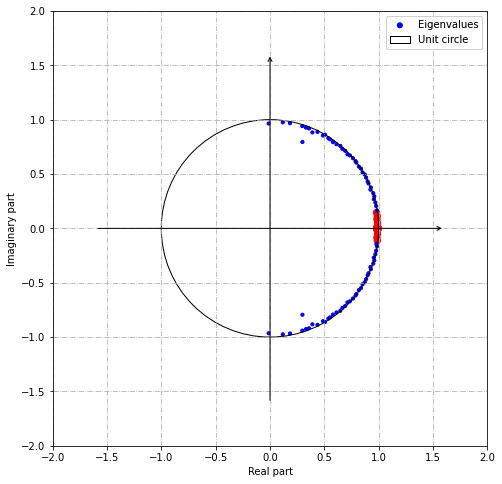

In [20]:
dmd_ext.plot_eigs(sort_mode='cri16')

sort_method: amp
sort_method: amp


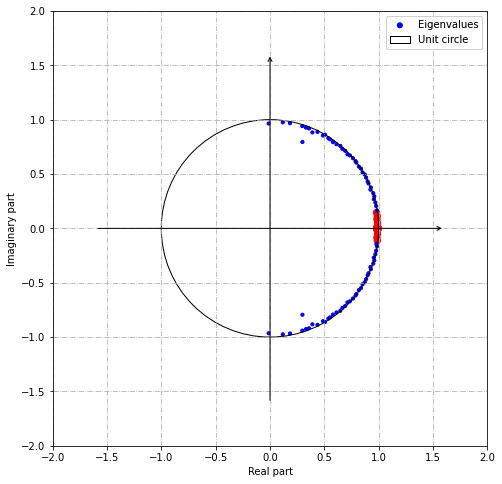

In [21]:
dmd_ext.plot_eigs(sort_mode='amp')

sort_method: amp
sort_method: amp
(87,)
sort_method: amp


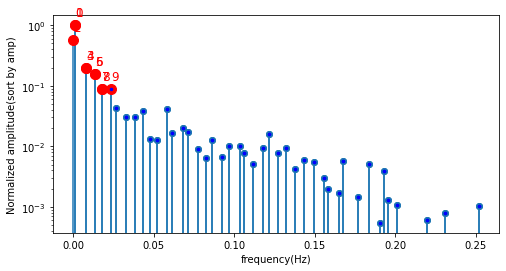

In [22]:
dmd_ext.plot_freq(n_sig=10, sort_mode='amp')

sort_method: cri16
sort_method: cri16
(87,)
sort_method: cri16


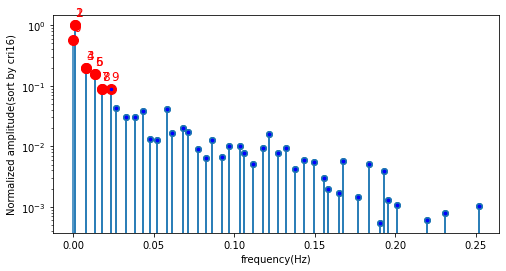

In [23]:
dmd_ext.plot_freq(n_sig=10, sort_mode='cri16')

sort_method: cri16
sort_method: cri16


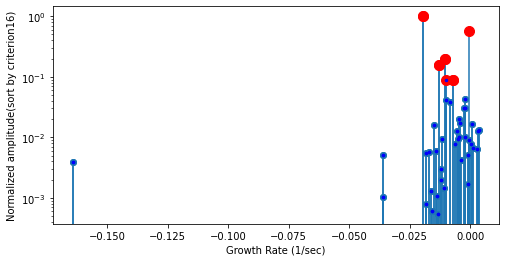

In [24]:
dmd_ext.plot_growthrate(n_sig=10, sort_mode='cri16')

sort_method: amp
sort_method: amp


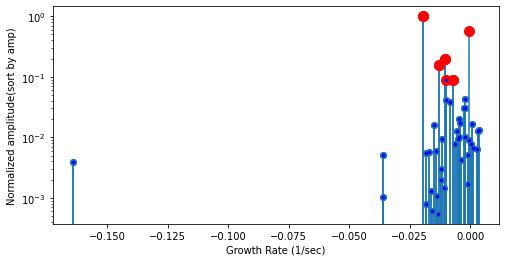

In [25]:
dmd_ext.plot_growthrate( sort_mode='amp')

In [26]:
dmd_ext.dynamics.shape

(87, 200)

In [27]:
Nc = 5
Nr= 15

In [28]:
vmax_real = dmd_ext.modes.real.max()
vmin_real = dmd_ext.modes.real.min()
vmax_img = dmd_ext.modes.imag.max()
vmin_img = dmd_ext.modes.imag.min()

vmax_abs = abs(dmd_ext.modes).max()
# vmin_abs = abs(dmd.modes).min()
vmin_abs = 0

In [29]:
value_amp_real = dmd_ext.modes[:, cri16_idx[:Nc*Nr]].real.T
values_real = np.reshape(value_amp_real, (-1, ny, nx))
# dmd_tools.plot_dmd_item(values_real, Nr, Nc, -vmax_real, vmax_real, title='real part of mode')

In [30]:
dmd_tools.plot_dmd_item(values_real, Nr, Nc, cmap='seismic', title='real part of mode', save_fig=True, png_name=save_dir+'Ureal'+f_suffix+'.png')

Output hidden; open in https://colab.research.google.com to view.

In [31]:
value_amp_imag = dmd_ext.modes[:, cri16_idx[:Nc*Nr]].imag.T
values_imag = np.reshape(value_amp_imag, (-1, ny, nx))
# dmd_tools.plot_dmd_item(values_imag, Nr, Nc, vmin_img, vmax_img, cmap='jet', title='imag part of mode')
dmd_tools.plot_dmd_item(values_imag, Nr, Nc, cmap='seismic', title='imag part of mode',save_fig=True,png_name=save_dir+'Uimag'+f_suffix+'.png')

Output hidden; open in https://colab.research.google.com to view.

In [32]:
value_real_amp_magnitude = np.absolute(dmd_ext.modes[:, cri16_idx[:Nc*Nr]]).T
values_magnitude = np.reshape(value_real_amp_magnitude, (-1, ny, nx))
values_magnitude_min = values_magnitude.min()
values_magnitude_max = values_magnitude.max()
# values_magnitude[values_magnitude<10e-5]=np.NaN
dmd_tools.plot_dmd_item(values_magnitude, Nr, Nc, cmap='seismic', title='magnitude of mode', save_fig=True, png_name=save_dir+'UReIm'+f_suffix+'.png')

Output hidden; open in https://colab.research.google.com to view.

In [33]:
## Phase plot 
# nrows, ncols = 10, 5
# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*2),
#                         subplot_kw={'xticks': [], 'yticks': []})
# value_real_amp = np.angle(dmd.modes[:, amp_idx[:nrows*ncols]])
# for ax, value in zip(axs.flat, np.reshape(value_real_amp, (nx, ny, -1)).T):
#     ax.imshow(value, cmap='plasma')

value_amp_phase = dmd_ext.modes[:, cri16_idx[:Nc*Nr]].T
values_phase = np.reshape(np.angle(value_amp_phase), (-1,ny, nx))
vmin_phase = values_phase.min()
vmax_phase = values_phase.max()
dmd_tools.plot_dmd_item(values_phase, Nr, Nc, vmin_phase, vmax_phase, cmap='plasma', title='phase of mode', save_fig=True,png_name=save_dir+'phase'+f_suffix+'.png')

Output hidden; open in https://colab.research.google.com to view.

sort_method: cri16


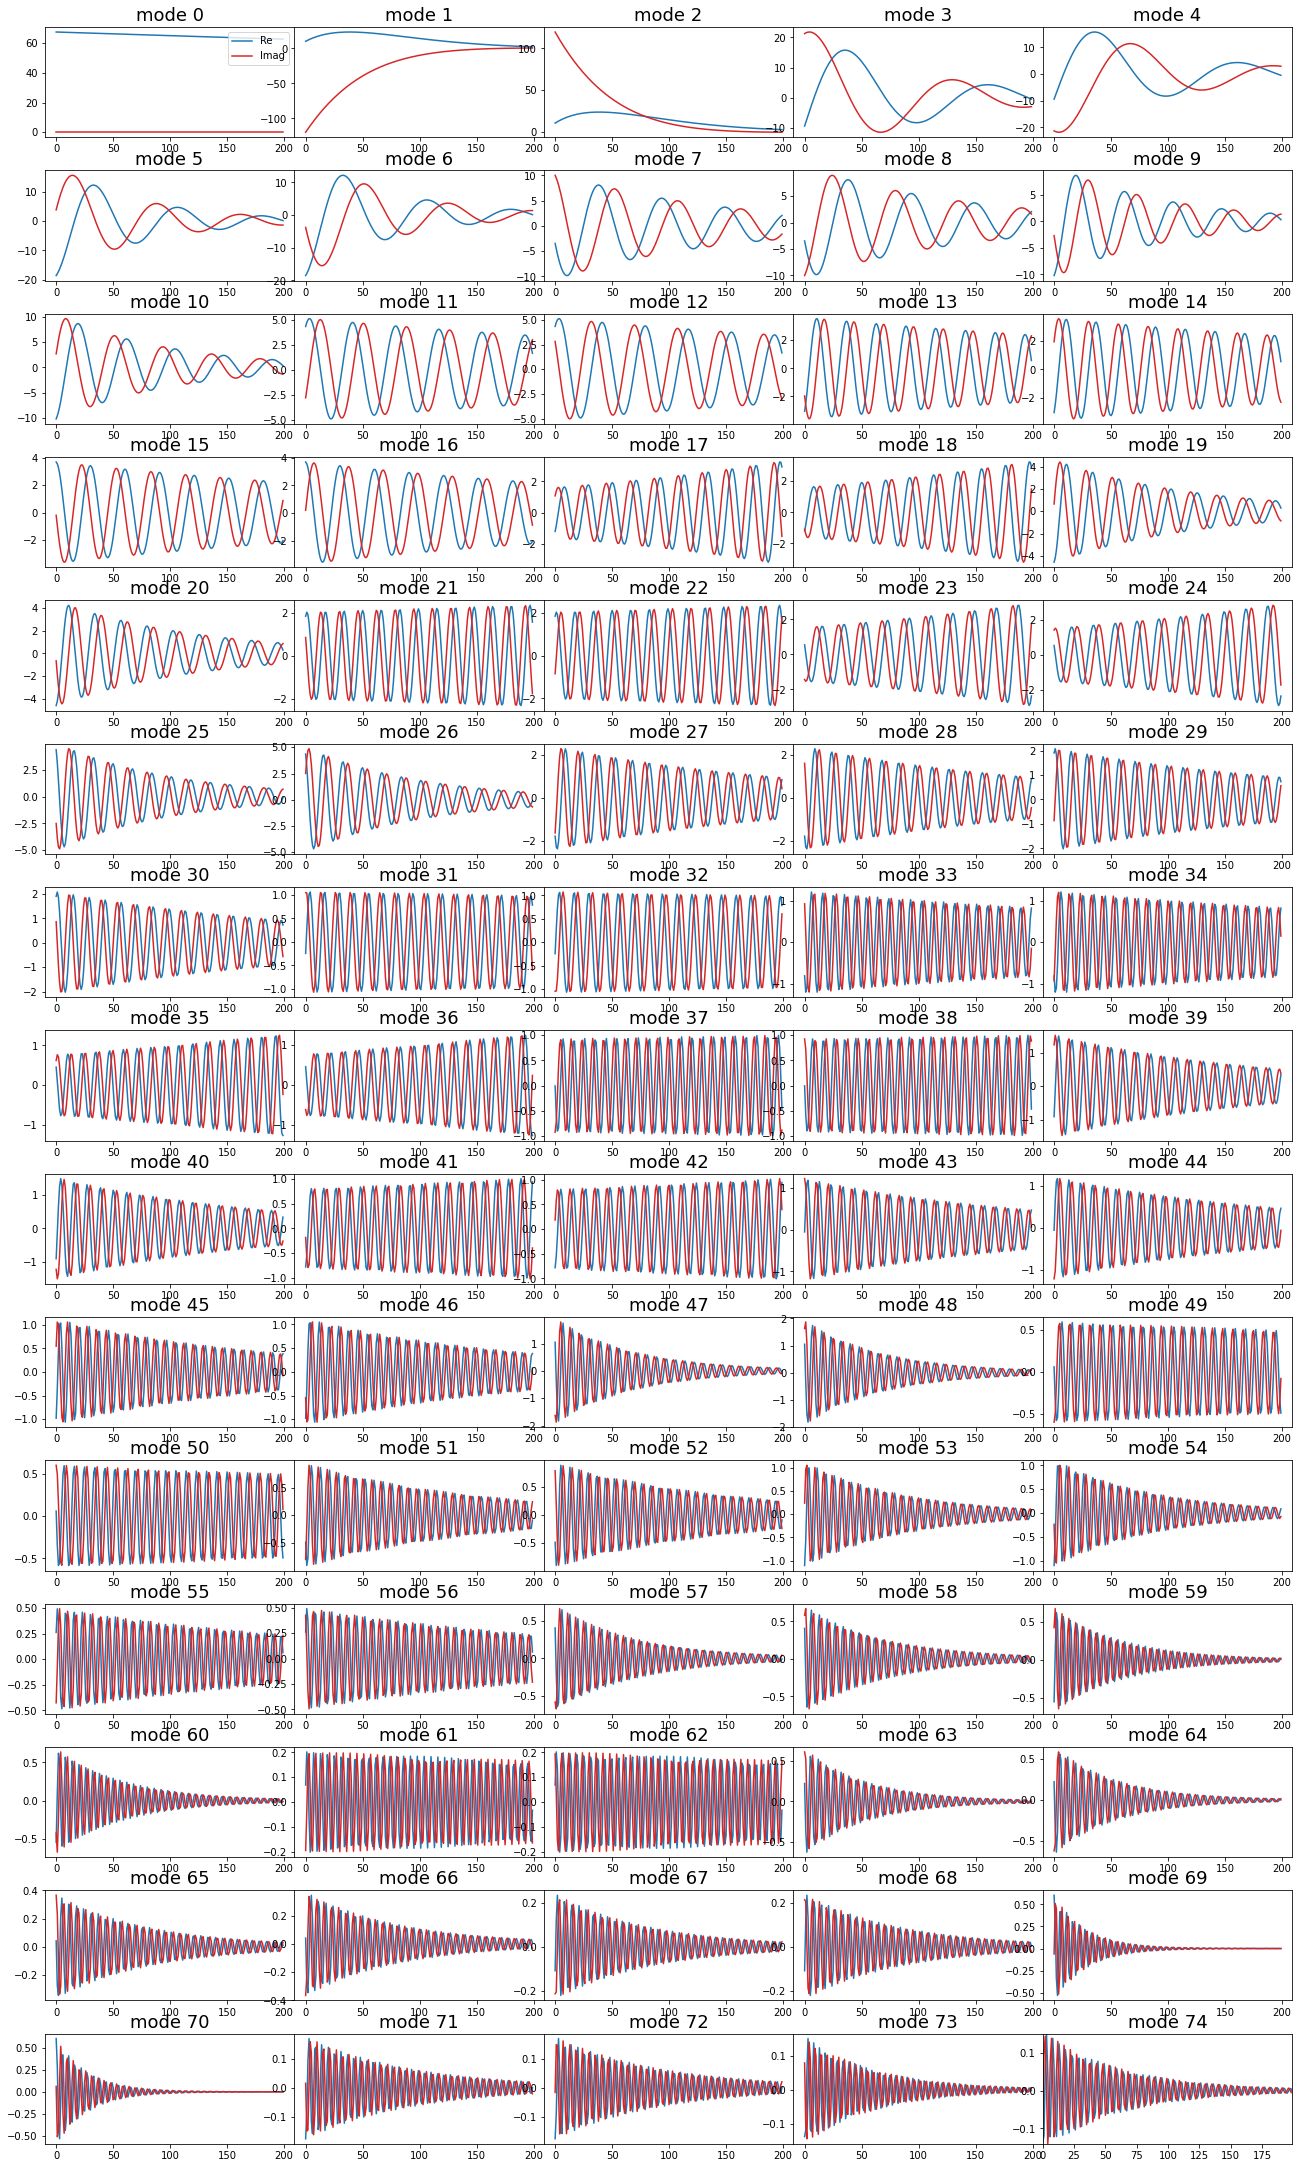

In [34]:
dmd_ext.plot_dynamics(Nr, Nc, sort_mode='cri16', save_fig=True, png_name='gdrive/My Drive/NTF_project/RBC_T3dynamics'+f_suffix+'.pdf')

In [35]:
# dmd_ext.plot_dynamics(Nr, Nc, sort_mode='amp', save_fig=True, png_name='gdrive/My Drive/NTF_project/RBC_dynamics.pdf')

In [36]:
# dmd_ext.plot_dynamics(Nr, Nc, sort_mode='amp')

sort_method: cri16
test


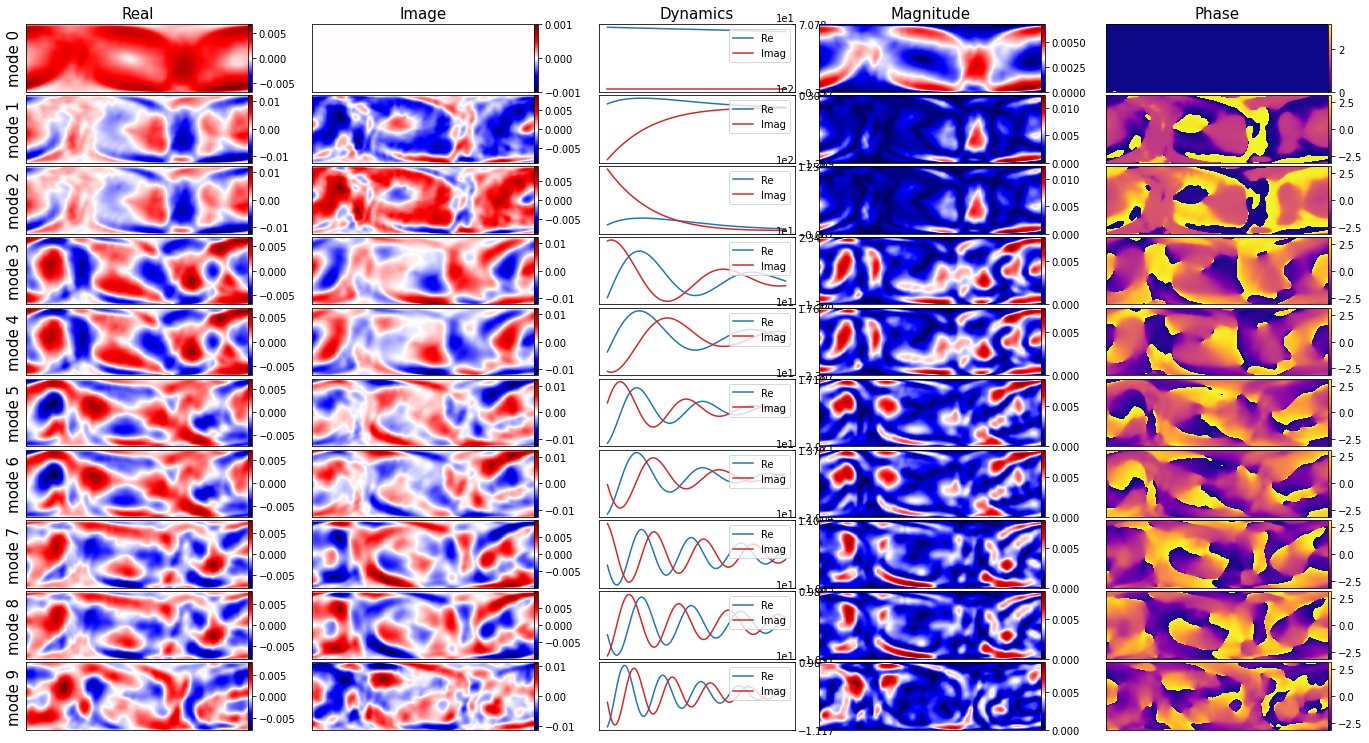

In [37]:
dmd_ext.plot_grid([i for i in range(10)], cmap='seismic',nx=nx, ny=ny, save_fig=True,png_name=save_dir+'all'+f_suffix+'.png')
# plt.savefig('gdrive/My Drive/NTF_project/all.pdf')

In [38]:
dir_dy_mode = png_name=save_dir+"dy_modesU"+f_suffix
# modes_name = [f'modes_{j:02}' for j in range(4)]
# [comm_tools.make_dir(os.path.join(dir_dy_mode, fn)) for fn in modes_name];
mode_nums = [ f"timestep_{i:04}.png" for  i in range(500)]
dy_mode_paths =[]
# for m in modes_name:
#     mm = []
#     for j in mode_nums:
#         mm.append(os.path.join(dir_dy_mode, m,j))
#     dy_mode_paths.append(mm)


In [39]:
save_dymodes = True
if save_dymodes:
    values_coll = []
    num_modes=20
    for i, j in enumerate(cri16_idx[:num_modes]):
                
            mode_name = f'mode{i:04d}_{j:04}'
            sep_modes_base = os.path.join(dir_dy_mode, mode_name)
            comm_tools.make_dir(sep_modes_base)
            print(f"saveing mode No. {i+1}/{num_modes}")
            print(f"saving path: {sep_modes_base}")

            values = np.outer(dmd_ext.modes[:, j], dmd_ext.dynamics[j, :]).real
            values = values.reshape(ny,nx,-1)
            values = comm_tools.rescale(values)
            for k in range(values.shape[-1]):

                pic_path = os.path.join(sep_modes_base, f'modes_num{k:04}.png')
                plt.imsave(pic_path, values[:,:,k],  cmap='seismic')
            # values_coll.append(values)

saveing mode No. 1/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0000_0062
saveing mode No. 2/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0001_0067
saveing mode No. 3/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0002_0068
saveing mode No. 4/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0003_0070
saveing mode No. 5/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0004_0069
saveing mode No. 6/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0005_0072
saveing mode No. 7/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0006_0071
saveing mode No. 8/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0007_0077
saveing mode No. 9/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0008_0078
saveing mode No. 10/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0009_0083
saveing mode No. 11/20
saving path: gdrive/My Drive/NTF_project/dy_modesUU_1/mode0010_0084
saveing 

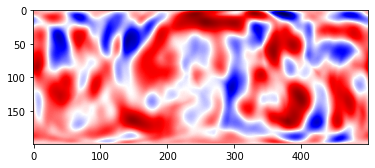

In [40]:
if save_dymodes:
    plt.imshow(values.reshape(ny,nx,-1)[:,:,0],cmap='seismic')